In [1]:
import matplotlib.pylab as plt
import numpy as np
import os
import dynamic_extrusion_boundaries.util_visual as utvis
import seaborn as sns
import pandas as pd
from scipy import ndimage
import matplotlib.ticker as tkr

### functions for loop size

In [2]:
def loop_size(t, v, delta, tau,  taup):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2 + (tau / ((tau + taup)*tau)) * v * ((t - (delta/2 / v))**2)
        if t > (tau+(delta/2)/(v)):
            loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2+(tau / (tau + taup)) * v * (t - (delta/2 / v) - tau/2) * 2
        return loop

def loop_size_static(t, v, delta, occupancy):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (1-occupancy) * v * (t - (delta/2 / v)) * 2
        return loop

### conversion parameters

In [3]:
TIME_CONV_COEF = 21.875*60/500 #to convert from lattice based to seconds
LATTICE_CONV_COEF = 0.25 #each lattice site is 0.25 kb

In [4]:
num_plot = 10
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


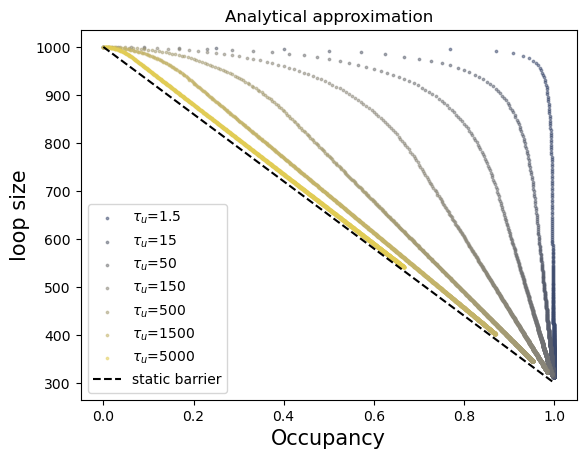

In [5]:
loop_for_high = []  # Renamed list to avoid conflict with function name
lifetime_range = [500]
taup_range = [1.5,15, 50, 150,500, 1500, 5000]
tau_range = np.arange(0,10000,5)
v_val_range = [1]
delta_val = 300
sep = 1000
i=1
sns.reset_defaults()

for v_val in v_val_range:
    for taup_val in taup_range:
        for lifetime in lifetime_range:
            i+=1
            loop_s = []
            for tau_val in tau_range:
                occup = np.round(tau_val/(tau_val+taup_val),3)
                loop_size_new = loop_size(lifetime, v_val, delta_val, tau_val, taup_val)
                loop_s.append([occup, loop_size_new])
            loop_s = np.array(loop_s)
            plt.scatter(loop_s[:,0],loop_s[:,1],label=r'$\tau_u$=%s'%(taup_val), s=3, alpha = 0.5, color= colors[i])


occupancy_range = np.arange(0,1.05,0.05)
lifetime_val = 500
loop_stat=[]
for occupancy_val in occupancy_range:
    loop_s = loop_size_static(lifetime_val,v=v_val,delta=delta_val,occupancy=occupancy_val)
    loop_stat.append([occupancy_val,loop_s])
loop_stat = np.array(loop_stat)
plt.plot(loop_stat[:,0],loop_stat[:,1],'--k',label='static barrier')
plt.title('Analytical approximation')
plt.ylabel('loop size', fontsize = 15)
plt.xlabel(r'Occupancy', fontsize = 15)
plt.legend()
plt.savefig('../output/figures/analytical_for_loop_size.png')
plt.show()  


In [6]:
loop_for_high = []  
lifetime_range = [500,1500]
tau_range = [1, 1.5, 3, 5, 10, 15,  30, 50, 100, 150, 500, 1000, 1500, 5000, 10000, 15000, 50000,  150000]
taup_range = [ 1.0, 1.5, 3,  5.0, 10.0, 15, 30,   50, 100, 150, 500, 1500,  5000, 10000]

v_val_range = [1,3]
delta_val = 300
sep = 1000
i=1
file = open('../output/scores/simulation/scores/loop_size_theoretical_est.csv','w')
file.write('lifetime,velocity,clife,cof,loopsize\n')
for vel in v_val_range:
    for taup_val in taup_range:
        for lifetime in lifetime_range:
            i+=1
            loop_s = []
            for tau_val in tau_range:
                new_loop_size = loop_size(lifetime, vel, delta_val, tau_val, taup_val)
                file.write('%s,%s,%s,%s,%s\n'%(lifetime,vel,tau_val,taup_val,new_loop_size))
                loop_s.append([tau_val/(tau_val+taup_val), new_loop_size])
            loop_s = np.array(loop_s)
file.close()

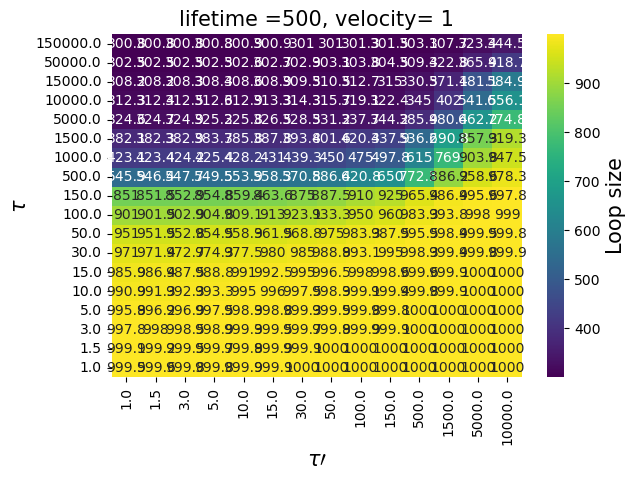

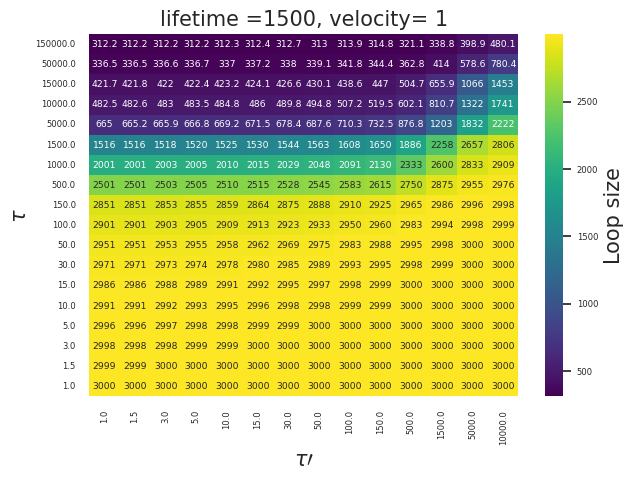

In [7]:
unique_vel = [ 1]

unique_life = [ 500, 1500]
file = pd.read_csv('../output/scores/simulation/scores/loop_size_theoretical_est.csv')

for life in list(unique_life):
    for vel in list(unique_vel):
        
        new_file = file.query('lifetime==@life and velocity==@vel')[['clife', 'cof', 'loopsize']]
        heatmap_data = new_file.pivot('clife', 'cof', 'loopsize')
        
        # Create the heatmap using seaborn
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis',  fmt='.4g', cbar_kws={'label': ' Loop size'})
        sns.set(font_scale=0.55)

        # Access the color bar object
        cbar = im.collections[0].colorbar
        
        # Set the font size of color bar label
        cbar.set_label('Loop size', fontsize=15)  # Adjust the font size as needed
        
        # Customize labels and title
        plt.xlabel(r'$\tau\prime$', fontsize=15)
        plt.ylabel(r'$\tau$', fontsize=15)
        plt.title('lifetime =%s, velocity= %s' % (life, vel),fontsize =15)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppt" which is no longer supported as of 3.3 and will become an error in 3.6


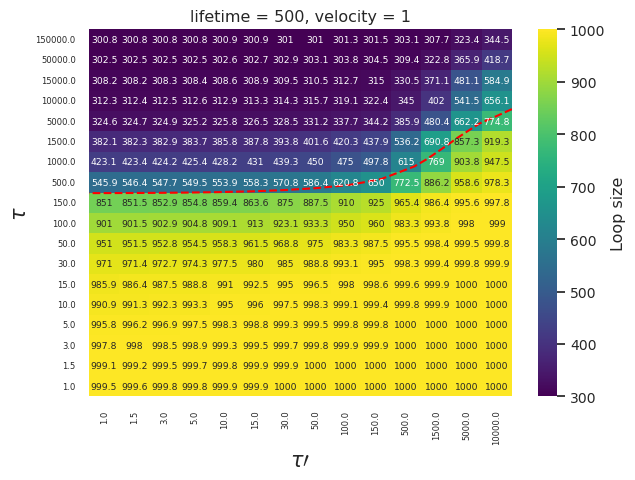

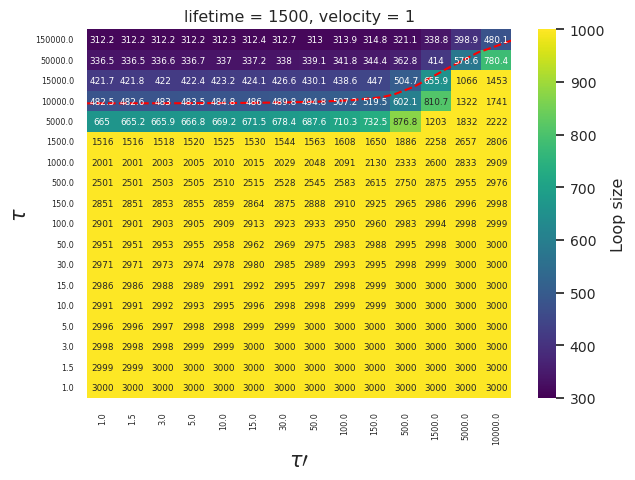

In [8]:
for life in unique_life:
    for vel in unique_vel:
        # Filter the data based on lifetime and velocity
        new_file = file.query('lifetime==@life and velocity==@vel')[['clife', 'cof', 'loopsize']]
        
        # Pivot the filtered data to create the heatmap data
        heatmap_data = new_file.pivot('clife', 'cof', 'loopsize')

        fig, ax = plt.subplots()
        
        # Create the heatmap using seaborn
        ax = sns.heatmap(heatmap_data, annot=True, vmin = 300, vmax= 1000,cmap='viridis', fmt='.4g', cbar_kws={'label': 'Loop size'})
        sns.set(font_scale=0.53)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label('Loop size', fontsize=11.5)

        # Add equipotential lines for loop size = 700
        
        fixed_loop = utvis.make_equipotential_lines(heatmap_data,[700], label = '',
                                             num_line_x = 14, num_line_y = 18, color='red', linestyles='dashed') 
        
        # Customize labels and title
        plt.xlabel(r'$\tau\prime$', fontsize=15)
        plt.ylabel(r'$\tau$', fontsize=15)
        plt.title('lifetime = %s, velocity = %s' % (life, vel), fontsize=11.5)
        
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig('../output/figures/figtheoretical_map_loopsize_life_%s_vel_%s.png'%(life,vel),ppt= 500)
        plt.show()


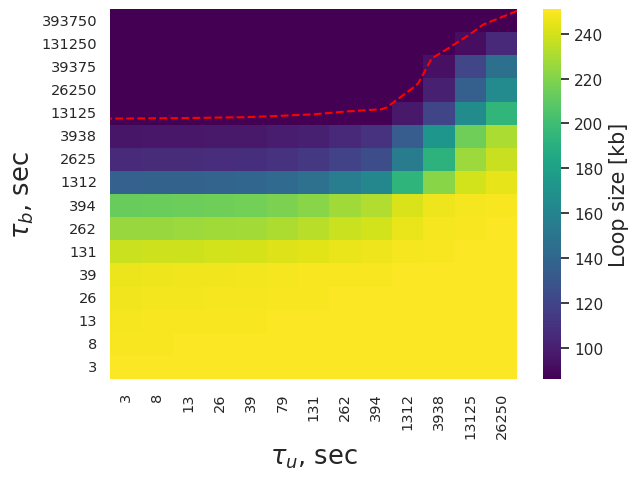

In [9]:
# Read the data from the CSV file
file = pd.read_csv('../output/scores/simulation/scores/loop_size_theoretical_est.csv')

# Define unique values for lifetime and velocity
unique_life = [500]
unique_vel = [1]

# Define tau and taup ranges
tau_range = [1, 3, 5, 10, 15, 50, 100, 150, 500, 1000, 1500, 5000, 10000, 15000, 50000, 150000]
taup_range = [1.0, 3, 5.0, 10.0, 15, 30, 50, 100, 150, 500, 1500, 5000, 10000, 15000]

# Loop through each combination of lifetime and velocity
for life in unique_life:
    for vel in unique_vel:
        # Filter the data based on lifetime and velocity
        new_file = file.query(
            'lifetime == @life and velocity == @vel and clife in @tau_range and cof in @taup_range'
        )[['clife', 'cof', 'loopsize']]
        
        # Convert and round the filtered data
        new_file['clife'] = (new_file['clife'] * TIME_CONV_COEF).round().astype(int)
        new_file['cof'] = (new_file['cof'] * TIME_CONV_COEF).round().astype(int)
        new_file['loopsize'] = new_file['loopsize'] * LATTICE_CONV_COEF
        
        # Pivot the filtered data to create the heatmap data
        heatmap_data = new_file.pivot('clife', 'cof', 'loopsize')

        # Create the heatmap using seaborn
        fig, ax = plt.subplots()
        smooth_scale = 1
        z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
        ax = sns.heatmap(heatmap_data, annot=False, vmin=86, vmax=251, cmap='viridis', fmt='.4g', cbar_kws={'label': 'Loop size'})
        
        # Customize the heatmap
        sns.set(font_scale=0.53)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11)
        cbar.set_label('Loop size [kb]', fontsize=14.95)
        
        # Add equipotential lines for loop size = 700
        number_tau = 13
        number_taup = 16
        cntr = ax.contour(np.linspace(0, number_tau, number_tau * smooth_scale),
                          np.linspace(0, number_taup, number_taup * smooth_scale),
                          heatmap_data.to_numpy(), levels=[350 * 0.25], colors='red', linestyles='dashed')
        
        # Customize labels and title
        plt.xticks(fontsize=10.51, rotation=90)
        plt.yticks(fontsize=10.51)
        plt.xlabel(r'$\tau_u$, sec', fontsize=18.5)
        plt.ylabel(r'$\tau_b$, sec', fontsize=18.5)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        
        # Save and display the heatmap
        plt.savefig(f'../output/figtheoretical_map_loopsize_life_{life}_vel_{vel}_abs.pdf', transparent=True)
        plt.show()

In [10]:
file = pd.read_csv('../output/scores/simulation/scores/loop_size_theoretical_est.csv')

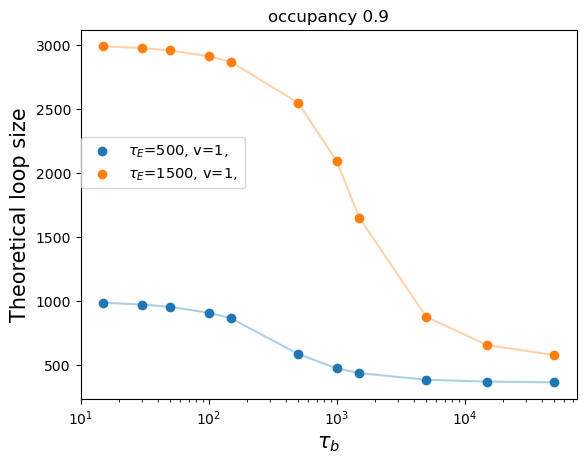

In [11]:
lifes, vels = [500, 1500] , [1]

sns.reset_defaults()
for life in lifes:
    for vel in vels:
        new_file = file.query('lifetime==@life and velocity==@vel and clife==10*cof')[['clife','cof', 'loopsize']]
        new_file_filtered = new_file.drop_duplicates(keep = 'first')
        new_file_filtered = new_file_filtered.sort_values('clife')
        new_clife = new_file_filtered['clife']
        frip_score = new_file_filtered['loopsize']
        plt.scatter(new_clife[1:], frip_score[1:], label=r'$\tau_E$=%s, v=%s, '%(life,vel))
        plt.plot(new_clife[1:], frip_score[1:], alpha = 0.35)

plt.xlim()
plt.title('occupancy 0.9')
plt.xscale('log')
plt.legend(fontsize = 10.51,loc = (0.001,0.57))
plt.ylabel('Theoretical loop size',fontsize = 15)
plt.xlabel(r'$\tau_b$', fontsize = 15)
plt.show()
        